# Lab 9: Techniques for training Deep Neural Netwoks

```
- Machine Learning, Innopolis University (Fall semester 2022)
- Professor: Adil Khan
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice techniques that are used to improve deep learning models perfomence in Pytorch.

Lab Plan
1. Data Augmentation examples
2. Batch normalization, Dropout, ...
3. Adaptive Learning rate and Optimizers
4. Using TensorBoard
5. Using Pretrained models (Transfer learning)

```
<hr>

# 1. CNN with PyTorch

## Load data and preprocess

To load our data set (CIFAR10) we can either download it manualy or use torchvision package. `torchvision` consists of popular datasets, model architectures, and common image transformations for computer vision.


For smooth training of the CNN we need to transform (normalize) the images. `transforms` package conatains common image transformations. Image transformations can be chained together using `transforms.Compose`. In our case we need to first convert image to tensor `transforms.ToTensor()` then normalize `transforms.Normalize`

The packages can be pip installed<br>
`!pip install torch` <br>
`!pip install torchvision`

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

batch_size = 128
test_batch_size = 100

# Transformations
# TODO : add data augmentation of your choice
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(0.3),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create Train Dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
trainloader1 = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#Create Test Dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Data visualization 
Create a simple method to have a look at the data (image)

 bird   car   dog  bird


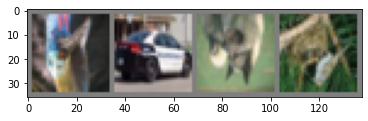

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Lets Switch to the GPU (if available) - why?


Unlike TensorFlow, PyTorch doesn’t have a dedicated library for GPU users,so its neccessary to some manual setup <br>
<b>NB: </b>If working on Colab, make sure that GPU runtime is enabled <br>
<b>NB: </b>It’s not possible to transfer Data Loaders directly to GPU <br>
<b>NB: </b> To get total number of GPU devices available `torch.cuda.device_count()`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [ ]:
#TODO: Create the BaseModel by defining the missing (None) convolutional layers, Max pool and fully connected layers
#TODO: Finish implementation of foward method in class BaseModel
import torch.nn as nn
import torch.nn.functional as F

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        
        # TODO 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # TODO
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        # TODO
        self.fc1 = nn.Linear(8*8*128, 256)
        self.fc2 = nn.Linear(256, 84)
        self.output = nn.Linear(84, 10)

    def forward(self, x):
        # TODO: Implement the foward pass method. NOTE: Apply Relu activation function to all layers
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 8*8*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)
        # order : conv1 -> activation -> conv2 -> activation -> pool1 -> conv3 -> activation -> pool2 -> fc1 -> activation -> fc2 -> activation -> output

model = BaseModel().to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print("Number of params in the CNN model:", count_parameters(model))

Number of params in the CNN model: 2213094


## 3. Training and testing

In [ ]:
import torch.optim as optim
def train_evaluate(net, optimizer, writer):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #TODO: Iterate through the batches and train the cnn
            # TODO : get the inputs and place them to the training devide (i.e GPU or CPU)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # TODO : Train procedure -> zero the gradients, forward pass + backward pass + optimize
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # TODO: print statistics and log loss to Tensorboard
        running_loss /= len(trainloader)
        optimizer = torch.optim.Adam(model.parameters())
        writer.add_scalar('Loss/train', running_loss, epoch)
        writer.add_scalar('Loss/test', running_loss, epoch)
        writer.add_scalar('Accuracy/train', running_loss, epoch)
        writer.add_scalar('Accuracy/test', running_loss, epoch)

    
    #Print Model overall Accuracy 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    #Print Model classwise Accuracy 
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

## Simple CNN training and Evaluation

In [ ]:
# TODO : define an optimizer SGD with learning rate 0.001 and momentum 0.9
optimizer = torch.optim.Adam(model.parameters())
train_evaluate(model, optimizer)

KeyboardInterrupt: 

## Improved CNN Model

### Task 
1. Add Dropout for both convolution and fully connected layers
2. Add Batch Normalization for convolutions
3. Add Batch Normalization for fully connected network

In [ ]:
#TODO: Create the ImprovedModel by defining the missing (None) batch Normalization layers and Dropout
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            None , # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            None,  # Dropout 25%
            
            nn.Conv2d(32,64,3,padding=1),
            None, # Batch Normalization
            nn.ReLU(),
            None,  # Dropout 25%
            
            nn.Conv2d(64,128,3,padding=1),
            None, # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            None,  # Dropout 25%
            
            nn.Conv2d(128,128,3,padding=1),
            None , # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Conv2d(128,128,3,padding=1),
            None, # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            None, # Dropout 25%
            
            nn.Flatten(),
            nn.Linear(None),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10))

    def forward(self, x):
        return self.network(x)

model_improved = ImprovedModel().to(device)

In [ ]:
print("Number of params in the CNN model:", count_parameters(model))

Number of params in the CNN model: 2213094


## Improved CNN training and Evaluation

In [ ]:
optimizer = torch.optim.Adam(model_improved.parameters(),lr=0.001)
train_evaluate(model_improved, optimizer)

[Epoch 1] Loss 1.5229
[Epoch 2] Loss 1.2268
[Epoch 3] Loss 1.0909
[Epoch 4] Loss 1.0057
[Epoch 5] Loss 0.9471
[Epoch 6] Loss 0.8981
[Epoch 7] Loss 0.8546
[Epoch 8] Loss 0.8245
[Epoch 9] Loss 0.7930
[Epoch 10] Loss 0.7744
Finished Training
Accuracy of the network on the 10000 test images: 72 %
Accuracy of plane : 84 %
Accuracy of   car : 87 %
Accuracy of  bird : 52 %
Accuracy of   cat : 72 %
Accuracy of  deer : 61 %
Accuracy of   dog : 68 %
Accuracy of  frog : 88 %
Accuracy of horse : 84 %
Accuracy of  ship : 64 %
Accuracy of truck : 79 %


## CNN from popular model architectures (Transfer learning)

Same procedure as simple CNN but the achitecture of the neural net is much more complicated and the weights are pretrained. <br> 


### Fine Tuning
Fine tuning or transfer learning is the task of training a model on a big dataset and then adjusting the parameters of the model for a smaller task with less data.

It is very common in Computer Vision and Natural Language Processing with the immergence of BERT and UMLfit. <br>
![](https://miro.medium.com/max/1276/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg)

Say we want to use resnet (trained on imagenet with 1000 classes and has input shape of 256x256)  and fine-tune it for CIFAR10 (has 10 categories with input shape of 32×32)

What is the biggest changes that we need to make?



## How to Import Popular CNN models? 

`torchvision,models` contains of popular model architectures and can be loaded together with their trained weights


In [ ]:
import torchvision.models as models

# resnet18 = models.resnet18(pretrained=True,progress=True)
# alexnet = models.alexnet(pretrained=True,progress=True)
# squeezenet = models.squeezenet1_0(pretrained=True,progress=True)
# vgg16 = models.vgg16(pretrained=True,progress=True)
# densenet = models.densenet161(pretrained=True,progress=True)
# inception = models.inception_v3(pretrained=True,progress=True)
# googlenet = models.googlenet(pretrained=True,progress=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True,progress=True)
# mobilenet = models.mobilenet_v2(pretrained=True,progress=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True,progress=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True,progress=True)
# mnasnet = models.mnasnet1_0(pretrained=True,progress=True)

## Start by loading and transforming the data 

In [ ]:
import torchvision.models as models

transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Define CNN model 

<b>NB : </b>To make the model architecture fit our classification task, we will change the last fully connected layer and train only it.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(weights='IMAGENET1K_V1', progress=True)
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)

## Self-practice Task


1. Add Tensorboard to monitor the train and validation loss, recall, precision and accuracy every after training epoch
2. Create another CNN using pretrained model and compare it with already implemented resnet and simple CNN (plot their losses on same tensorboard)

### Task1

In [1]:
import torch
from torchmetrics import Recall, Precision, Accuracy 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import  time

batch_size = 128
test_batch_size = 128

# Transformations
# TODO : add data augmentation of your choice
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(0.3),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create Train Dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#Create Test Dataloader
valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [4]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # TODO
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # TODO
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # TODO
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, 84)
        self.output = nn.Linear(84, 10)

    def forward(self, x):
        # TODO: Implement the foward pass method. NOTE: Apply Relu activation function to all layers
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)
        # order : conv1 -> activation -> conv2 -> activation -> pool1 -> conv3 -> activation -> pool2 -> fc1 -> activation -> fc2 -> activation -> output

model = BaseModel().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
         MaxPool2d-5            [-1, 128, 8, 8]               0
            Linear-6                  [-1, 256]       2,097,408
            Linear-7                   [-1, 84]          21,588
            Linear-8                   [-1, 10]             850
Total params: 2,213,094
Trainable params: 2,213,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.19
Params size (MB): 8.44
Estimated Total Size (MB): 9.64
----------------------------------------------------------------


In [3]:
epochs = 10
def train_evaluate(net, optimizer, writer):
    starttime = time.time()
    criterion = nn.CrossEntropyLoss()
    accuracy_func = Accuracy(num_classes=10, average='weighted').to(device)
    recall_func = Recall().to(device)
    precision_func = Precision().to(device)

    for epoch in range(epochs):

        running_loss = 0.0
        accuracy = 0
        recall = 0
        precision = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, pred = torch.max(outputs.data, 1)
            accuracy += accuracy_func(pred, labels) * 100
            recall += recall_func(pred, labels) * 100
            precision += precision_func(pred, labels) * 100

        running_loss /= len(trainloader)
        accuracy /= len(trainloader)
        recall /= len(trainloader)
        precision /= len(trainloader)
        writer.add_scalar('Training_Loss', running_loss, epoch)
        writer.add_scalar('Training_Accuracy', accuracy, epoch)
        writer.add_scalar('Training_Recall', recall, epoch)
        writer.add_scalar('Training_Precision', precision, epoch)


        print('Epoch {} - train loss:{}, accuracy:{}, time passed {}s'.format(epoch+1, running_loss, accuracy, int(time.time()-starttime)))

        val_loss = 0.0
        val_accuracy = 0
        val_recall = 0
        val_precision = 0

        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                val_loss += loss.item()
                val_accuracy += accuracy_func(pred, labels) * 100
                val_recall += recall_func(pred, labels) * 100
                val_precision += precision_func(pred, labels) * 100

            val_loss /= len(valloader)
            val_accuracy /= len(valloader)
            val_recall /= len(valloader)
            val_precision /= len(valloader)

            writer.add_scalar('Val_Loss', val_loss, epoch)
            writer.add_scalar('Val_Accuracy', val_accuracy, epoch)
            writer.add_scalar('Val_Recall', val_recall, epoch)
            writer.add_scalar('Val_Precision', val_precision, epoch)

        print('Epoch {} - val loss:{}, accuracy:{}, time passed {}s'.format(epoch+1, val_loss, val_accuracy,  int(time.time()-starttime)))

In [8]:
optimizer = torch.optim.Adam(model.parameters())
writer = SummaryWriter('runs/lab9/simpleCNN')
train_evaluate(model, optimizer, writer)

Epoch 1 - train loss:1.0569633068635946, accuracy:62.06441879272461, time passed 45s
Epoch 1 - val loss:0.9887787639340267, accuracy:64.6756362915039, time passed 54s
Epoch 2 - train loss:0.9053687895350444, accuracy:67.8960189819336, time passed 101s
Epoch 2 - val loss:0.9045860676825801, accuracy:67.78085327148438, time passed 112s
Epoch 3 - train loss:0.782787695260304, accuracy:72.30298614501953, time passed 168s
Epoch 3 - val loss:0.8613802835911135, accuracy:69.47191619873047, time passed 176s
Epoch 4 - train loss:0.6871593373510844, accuracy:75.64737701416016, time passed 225s
Epoch 4 - val loss:0.8337543689751927, accuracy:70.72785186767578, time passed 236s
Epoch 5 - train loss:0.6006651279871421, accuracy:78.84510803222656, time passed 283s
Epoch 5 - val loss:0.8242959553682352, accuracy:71.46954345703125, time passed 291s
Epoch 6 - train loss:0.5224344988003411, accuracy:81.63603210449219, time passed 335s
Epoch 6 - val loss:0.839801056475579, accuracy:71.855224609375, time 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(weights='IMAGENET1K_V1', progress=True)
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [10]:
optimizer = torch.optim.Adam(net.parameters())
writer = SummaryWriter('runs/lab9/resnet')
train_evaluate(net, optimizer, writer)

Epoch 1 - train loss:1.0669170686655947, accuracy:62.98553466796875, time passed 154s
Epoch 1 - val loss:0.9242201704013197, accuracy:68.45332336425781, time passed 164s
Epoch 2 - train loss:0.7772764291452325, accuracy:73.35357666015625, time passed 323s
Epoch 2 - val loss:0.9126824842223639, accuracy:69.87737274169922, time passed 334s
Epoch 3 - train loss:0.6559879050382873, accuracy:77.59510803222656, time passed 491s
Epoch 3 - val loss:0.8079986576038071, accuracy:72.99248504638672, time passed 500s
Epoch 4 - train loss:0.5719359525481759, accuracy:80.4427719116211, time passed 665s
Epoch 4 - val loss:0.7625397760656816, accuracy:74.90110778808594, time passed 678s
Epoch 5 - train loss:0.5159824037033579, accuracy:82.39330291748047, time passed 834s
Epoch 5 - val loss:0.8050884136670753, accuracy:74.49565124511719, time passed 844s
Epoch 6 - train loss:0.454458064816492, accuracy:84.59998321533203, time passed 1006s
Epoch 6 - val loss:0.7748858558980725, accuracy:75.1186752319336,

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.shufflenet_v2_x2_0()
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.fc = nn.Linear(2048, 10)

    def forward(self, x):
        return self.net(x)

shuff = Net().to(device)
summary(shuff, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              ReLU-3           [-1, 24, 16, 16]               0
         MaxPool2d-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 24, 4, 4]             216
       BatchNorm2d-6             [-1, 24, 4, 4]              48
            Conv2d-7            [-1, 122, 4, 4]           2,928
       BatchNorm2d-8            [-1, 122, 4, 4]             244
              ReLU-9            [-1, 122, 4, 4]               0
           Conv2d-10            [-1, 122, 8, 8]           2,928
      BatchNorm2d-11            [-1, 122, 8, 8]             244
             ReLU-12            [-1, 122, 8, 8]               0
           Conv2d-13            [-1, 122, 4, 4]           1,098
      BatchNorm2d-14            [-1, 12

In [8]:
optimizer = torch.optim.Adam(shuff.parameters())
writer = SummaryWriter('runs/lab9/shuff')
train_evaluate(shuff, optimizer, writer)

Epoch 1 - train loss:1.8099873870839853, accuracy:34.54203796386719, time passed 69s
Epoch 1 - val loss:1.5894068539897097, accuracy:42.592960357666016, time passed 77s
Epoch 2 - train loss:1.5120637828431776, accuracy:45.88515090942383, time passed 142s
Epoch 2 - val loss:1.5226520858233488, accuracy:43.769779205322266, time passed 150s
Epoch 3 - train loss:1.3453806385664684, accuracy:51.73833084106445, time passed 217s
Epoch 3 - val loss:1.3490767282775686, accuracy:51.918514251708984, time passed 227s
Epoch 4 - train loss:1.2362519484346786, accuracy:55.862770080566406, time passed 298s
Epoch 4 - val loss:1.3394668162623538, accuracy:52.07674026489258, time passed 305s
Epoch 5 - train loss:1.1570540808350838, accuracy:58.93901824951172, time passed 373s
Epoch 5 - val loss:1.2708812552162363, accuracy:55.696205139160156, time passed 381s
Epoch 6 - train loss:1.0803683448935408, accuracy:61.6032600402832, time passed 449s
Epoch 6 - val loss:1.2300076899649222, accuracy:57.00158309936

In [9]:
%load_ext tensorboard

In [10]:
%tensorboard --logdir runs/lab9

Launching TensorBoard...